# Analysis of detached housing sales in select zip codes of western Prince William County, Virginia, 1/1/2000 - 7/13/2021

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
%pylab inline
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline

import joblib
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text, export_graphviz
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RepeatedKFold, cross_val_score

Populating the interactive namespace from numpy and matplotlib


## Import Data

In [2]:
# dataset containing detached sales
df = pd.read_csv('data/detached_sales.csv')

In [3]:
# dataset containing listing brokerage and listing agent data for all detached sales
broker_df = pd.read_csv('data/mls_with_broker.csv')

In [4]:
# dataset containing lat and long for detached sales
geocode_df = pd.read_csv('data/transactions_full_address_geocodio.csv')

In [5]:
# dataset containing 10 Yr Treasury bond yields since 1/1/1999
yields_df = pd.read_csv('data/historical_daily_ten_year_treasury_rates.csv')

## Dataset Cleaning

### Brokerage Data (broker_df)

In [6]:
broker_df.head(2)

,MLS #,List Agent Full Name,List Office Name,List Office Code,List Office Broker Of Record ID
0,VAPW524270,Kathryn L Gwartney,Homestead Realty,HOMD1,98356.0
1,VAPW525438,Kelly Martinez,Coldwell Banker Realty,CBRB58,113312.0


In [7]:
# format broker_df column headers
broker_df.columns = broker_df.columns.str.strip()
broker_df.columns = broker_df.columns.str.replace(' ', '_', regex=False)
broker_df.columns = broker_df.columns.str.lower()

### Geocode Data (geocode_df)

In [8]:
geocode_df.head(2)

,Unnamed: 0,mls_#,address,zip_code,city,full_address,Latitude,Longitude,Accuracy Score,Accuracy Type,Number,Street,Unit Type,Unit Number,City,State,County,Zip,Country,Source
0,0,VAPW289124,10087 Post Oak Terrace,20110,Manassas,"10087 Post Oak Terrace, Manassas, VA 20110",38.729593,-77.499939,0.87,rooftop,10087.0,Post Oak Ter,NaN,NaN,Manassas,VA,Prince William County,20110,US,Prince William
1,1,VAPW250326,7409 Howell Run Ct,20112,Manassas,"7409 Howell Run Ct, Manassas, VA 20112",38.672905,-77.425982,1.00,rooftop,7409.0,Howell Run Ct,NaN,NaN,Manassas,VA,Prince William County,20112,US,Prince William


In [9]:
# format geocode_df column headers
geocode_df.columns = geocode_df.columns.str.strip()
geocode_df.columns = geocode_df.columns.str.replace(' ', '_', regex=False)
geocode_df.columns = geocode_df.columns.str.lower()

# keep only select columns of original geocode_df
geocode_df = geocode_df[['mls_#',
                         'latitude',
                         'longitude']]

# due to miscoded latitudes and longitudes from geocodio, provide correction factors to all latitudes and longitudes
latitude_correction = 0.0000043
longitude_correction = 0.0023
geocode_df['longitude'] = geocode_df.longitude - longitude_correction
geocode_df['latitude'] = geocode_df.latitude - latitude_correction

### 10 Year Treasury Bond Yield Data (yields_df)

In [10]:
yields_df.head(2)

,DATE,DGS10
0,1/4/99,4.69
1,1/5/99,4.74


In [11]:
# format yields_df column headers
yields_df.columns = yields_df.columns.str.strip()
yields_df.columns = yields_df.columns.str.replace(' ', '_', regex=False)
yields_df.columns = yields_df.columns.str.lower()
yields_df.rename(columns={'dgs10': 'rate_pct'},
                 inplace=True)

# convert date column to datetime format
yields_df['date'] = pd.to_datetime(yields_df['date'])

# convert non-trading day values from '.' to np.nan and then use forward fill to replace the np.nan with the previous trading day's rte
yields_df.loc[yields_df['rate_pct'] == '.', ['rate_pct']] = np.nan
yields_df['rate_pct'].fillna(method='ffill',
                             inplace=True)
yields_df['rate_pct'] = yields_df['rate_pct'].astype(float)

# create duplicate date column and establish original date column as dataframe index
yields_df['day'] = yields_df.loc[:, 'date']
yields_df.set_index('date',
                    inplace=True)


### Detached Sales (df)

In [12]:
# format column headers
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('/', '_')
df.columns = df.columns.str.lower()

# format date columns
df['listing_entry_date'] = pd.to_datetime(df.listing_entry_date)
df['listing_entry_month'] = pd.DatetimeIndex(df.listing_entry_date).month
df['listing_entry_year'] = pd.DatetimeIndex(df.listing_entry_date).year

df.rename(columns={'agreement_of_sale_signed_lease_date': 'agreement_of_sale_date'},
          inplace=True)
df['agreement_of_sale_date'] = pd.to_datetime(df.agreement_of_sale_date)
df['agreement_of_sale_month'] = pd.DatetimeIndex(df.agreement_of_sale_date).month
df['agreement_of_sale_year'] = pd.DatetimeIndex(df.agreement_of_sale_date).year

df['close_date'] = pd.to_datetime(df.close_date)
df['close_month'] = pd.DatetimeIndex(df.close_date).month
df['close_year'] = pd.DatetimeIndex(df.close_date).year

# keep observations that contain a close price
df = df.loc[df.close_price.notnull(), :]

# format original_list_price, list_price and close price
df['original_list_price'] = df.original_list_price.str.replace('$', '', regex=False)
df['original_list_price'] = df.original_list_price.str.replace(',', '')
df['original_list_price'] = df.original_list_price.str.split('.', 1, expand=True)[0].astype(int)

df['list_price'] = df.list_price.str.replace('$', '', regex=False)
df['list_price'] = df.list_price.str.replace(',', '')
df['list_price'] = df.list_price.str.split('.', 1, expand=True)[0].astype(int)

df['close_price'] = df.close_price.str.replace('$', '', regex=False)
df['close_price'] = df.close_price.str.replace(',', '')
df['close_price'] = df.close_price.str.split('.', 1, expand=True)[0].astype(int)

# fix close prices that were incorrectly recorded
# MLS # VAPW273384 looks as if the agent did not input the correct closing price, so the close_price will be changed to $322,000 from 2200.
# MLS # 1002244130 looks as if the agent did not add the trailing two 0s to the sale documentation, so the close_price will be changed to $431,000
df.loc[df['mls_#'] == 'VAPW273384', 'close_price'] = 322000
df.loc[df['mls_#'] == '1002244130', 'close_price'] = 431000

# create column to calculate the week number of the year that the house was listed in the mls
list_week_nums = []
for date, week in zip(df['listing_entry_date'], df['listing_entry_date'].dt.strftime('%W')):
    # print(date, week)
    list_week_nums.append(week)
# print(list_week_nums)
df['list_week_num'] = list_week_nums
df['list_week_num'] = df['list_week_num'].astype(int)

# create column to calculate the week number of the year that the house was sold
close_week_nums = []
for date, week in zip(df['close_date'], df['close_date'].dt.strftime('%W')):
    # print(date, week)
    close_week_nums.append(week)
# print(week_nums)
df['close_week_num'] = close_week_nums
df['close_week_num'] = df['close_week_num'].astype(int)

# create column for complete address
df['full_address'] = df.address + ', ' + df.city + ', VA ' + df.zip_code.astype('str')

# format zip code column
df['zip_code'] = df['zip_code'].astype(int).astype(str)

# update zip codes that are wholly within other zip codes
# Three zip codes are contained wholly within other zip codes. These three zip codes account for only 23 detached sales for the time period covered in this analysis. These three zip codes are being recoded to the larger zip code within which they reside.
df.loc[df.zip_code == '20108', 'zip_code'] = '20110'
df.loc[df.zip_code == '20156', 'zip_code'] = '20155'
df.loc[df.zip_code == '20168', 'zip_code'] = '20169'

# format days on market
df['dom'] = df.dom.str.replace(',', '', regex=False)
df['dom'] = df.dom.astype(float)

# create derived list date for the property
# assumes list date is day 1 of counter
# assumes continuous accumulation and no pauses until agreement list date
df = df.loc[df.agreement_of_sale_date.notnull(), :]
df['derived_list_date'] = (df['agreement_of_sale_date'] - pd.to_timedelta(df['dom'], unit='D')) + pd.DateOffset(1)
df['derived_list_date'] = pd.to_datetime(df.derived_list_date)
df['derived_list_date_month'] = pd.DatetimeIndex(df.derived_list_date).month
df['derived_list_date_year'] = pd.DatetimeIndex(df.derived_list_date).year

derived_list_week_nums = []
for date, week in zip(df['derived_list_date'], df['derived_list_date'].dt.strftime('%W')):
    # print(date, week)
    derived_list_week_nums.append(week)
# print(derived_list_week_nums)
df['derived_list_week'] = derived_list_week_nums
df['derived_list_week'] = df['derived_list_week'].astype(int)

# format HOA column
df.rename(columns={'hoa_yn': 'hoa'}, inplace=True)
hoa_map = {'Yes': 1,
           'No': 0}

df['hoa'] = df.hoa.replace(hoa_map).astype('int')

# format garage column
garage_map = {'Yes': 1,
              'No': 0}
df['garage'] = df.garage.replace(garage_map).astype('int')

# format garage spaces column
# Based on a spotcheck of some of the entries that are NaN, the houses with NaN for total garage spaces are NaN because the real estate agent left the field blank instead of entering in a 0.  I will replace all NaN values in the total garage spaces column with 0.
df.total_garage_spaces.fillna(0,
                              inplace=True)

# format bathrooms-full column
# In looking at the distribution of full bathrooms, most houses have between 0 and 7.
# Several properties have likely erroneous numbers of full bathrooms, for those listings that have more than 7 full bathrooms, the number of full bathrooms will be changed to 7
df.loc[df.bathrooms_full >= 8, 'bathrooms_full'] = 7

# format bathrooms-half column
# Approximately 1400 listings have null values for half bathrooms. Based on inspection of listings with NaN for the half bathrooms, it appears that agents left the half bathroom field blank instead of putting a 0. I manually updated the NaNs to zero.
# Approximately 10 listings have 10 or more half bathrooms. Listings with 4 or more half bathrooms will be manually changed to 4 half bathrooms
df.bathrooms_half.fillna(0,
                         inplace=True)
df.loc[df.bathrooms_half >= 4, 'bathrooms_half'] = 4

# format fireplaces_total column
# Approximately 1230 listings have null values for total number of fireplaces. Upon inspection, some houses with NaN truly have no fireplaces while some houses do have fireplaces. As a result of the inconsistency in the data, the NaNs will be dropped from the dataframe.
df = df.loc[df.fireplaces_total.notnull(), :]
df.loc[df['fireplaces_total'] >= 10, ['fireplaces_total']] = 1

# format condo_coop_assoc_yn column
# Three listings have a null value for condo_coop_assoc. Upon inspection of these:
# 9547 Laurencekirk Pl, Bristow is not a condo_coop so it will be changed to No
# 12868 Vint Hill Rd, Nokesville is not a condo_coop so it will be changed to No
# 8163 Snead Loop, Gainesville is not a condo_coop so it will be changed to No
df.rename(columns={'condo_coop_assoc_yn': 'condo_coop_assoc'},
          inplace=True)
df.condo_coop_assoc.fillna('No',
                           inplace=True)
condo_coop_map = {'Yes': 1,
                  'No': 0}
df['condo_coop_assoc'] = df['condo_coop_assoc'].replace(condo_coop_map)

# format basement column
basement_map = {'Yes': 1,
                'No': 0}
df['basement'] = df.basement.replace(basement_map)

# format levels_stories column
# keep only those sales that the real estate agent entered a value for the house
df = df.loc[df.levels_stories.notnull(), :]

# clean up levels and stories values
# 65 houses have no reported levels or stories, which does not seem plausible. I performed a spotcheck of those houses that have NaNs. Based on investigation, some of the listings are for plots of land, some are houses with one level and others are multileveled houses. Because of the inconsistency of the listings, they will be dropped from the dataframe.
# Investigate the listings that have 'other' as the number of levels. Based on a spotcheck, houses with 'other' will be manually changed to 4 levels and stories. This is due to the inconsistency of the data. These houses appear to have multiple stories and levels.
# There is no consistency to what a level or story constitutes, which is why there is a prevalence of 1.5, 2.5, and 3.5 levels.  In order to bring a sense of logic to the levels and stories of a house, a house can have between 1 and 4 levels or stories. Houses with a half level or story get rounded up to the next whole number level or story. Houses with 3.5, other or more levels or stories is capped at 4 levels.
df.loc[df.levels_stories == 1, 'levels_stories'] = 1
df.loc[df.levels_stories == '1', 'levels_stories'] = 1
df.loc[df.levels_stories == 1.5, 'levels_stories'] = 2
df.loc[df.levels_stories == '1.5', 'levels_stories'] = 2
df.loc[df.levels_stories == 2, 'levels_stories'] = 2
df.loc[df.levels_stories == '2', 'levels_stories'] = 2
df.loc[df.levels_stories == 2.5, 'levels_stories'] = 3
df.loc[df.levels_stories == '2.5', 'levels_stories'] = 3
df.loc[df.levels_stories == 3, 'levels_stories'] = 3
df.loc[df.levels_stories == '3', 'levels_stories'] = 3
df.loc[df.levels_stories == 3.5, 'levels_stories'] = 4
df.loc[df.levels_stories == '3.5', 'levels_stories'] = 4
df.loc[df.levels_stories == '3+', 'levels_stories'] = 3
df.loc[df.levels_stories == 4, 'levels_stories'] = 4
df.loc[df.levels_stories == '4', 'levels_stories'] = 4
df.loc[df.levels_stories == '5', 'levels_stories'] = 4
df.loc[df.levels_stories == 'Other', 'levels_stories'] = 4

df['levels_stories'] = df['levels_stories'].astype(float)

# format year_built column
# keep only those houses that the real estate agent entered a value for the year the house was built
df = df.loc[df.year_built.notnull(), :]
# keep only those houses that the real estate agent entered a value other than zero for the year the house was built
df = df.loc[df.year_built != 0, :]
# keep only those houses that were built after a specified year
build_year = 1950
df = df.loc[df.year_built >= build_year, :]

# format lot_size_sqft column
# keep only those houses whose lot size is not null
df = df.loc[df.lot_size_sqft.notnull(), :]
df = df.loc[df.lot_size_sqft != 0, :]

# create column to calculate delta between list price and close price
df['list_to_close_price_pct_delta'] = (((df.close_price - df.list_price) / df.list_price) * 100)

# sort dataframe by close_date column
df = df.sort_values(by='close_date')

# reset index of resulting dataset
df = df.reset_index(drop=True)

### Merge Dataframes

In [13]:
# merge broker_df with df, resulting dataframe called df
df = pd.merge(df, broker_df, on='mls_#', how='inner')

# merge geocode_df with df, resulting dataframe called df
df = pd.merge(df, geocode_df, on='mls_#', how='inner')

In [14]:
print(df.head(5).to_string())

        mls_#                 address zip_code         city listing_entry_date agreement_of_sale_date chg_info   dom close_date  original_list_price  list_price  close_price  year_built above_grade_finished_sqft below_grade_finished_sqft total_finished_sqft  lot_size_sqft  beds  bathrooms_full  bathrooms_half subdivision_neighborhood                       school_district structure_type  basement  fireplaces_total  levels_stories  total_garage_spaces  condo_coop_assoc fireplace  garage  hoa  listing_entry_month  listing_entry_year  agreement_of_sale_month  agreement_of_sale_year  close_month  close_year  list_week_num  close_week_num                                full_address derived_list_date  derived_list_date_month  derived_list_date_year  derived_list_week  list_to_close_price_pct_delta list_agent_full_name                   list_office_name list_office_code  list_office_broker_of_record_id   latitude  longitude
0  VAPW289124  10087 Post Oak Terrace    20110     Manassas         19

In [15]:
df.to_csv('data/exports/final_df.csv')

### Derivative Dataframes

In [16]:
# create grouped by week days on market dataframe
dom_weekly_df = df.groupby(pd.Grouper(key='close_date', axis=0, freq='7D', sort=True))['dom'].agg(['size', 'mean', 'median'])

In [17]:
# create grouped by month days on market dataframe
dom_monthly_df = df.groupby(pd.Grouper(key='close_date', axis=0, freq='M'))['dom'].agg(['size', 'mean', 'median'])

In [18]:
# create grouped by week yield rates dataframe
yields_weekly_df = yields_df.rate_pct.resample('W', label='left').agg(['size', 'mean', 'median'])

In [19]:
# create grouped by month yield rates dataframe
yields_monthly_df = yields_df.rate_pct.resample('M').agg(['size', 'mean', 'median'])

In [20]:
yields_monthly_df.loc[yields_monthly_df.index > '2014-12-31', :]

,size,mean,median
date,,,
2015-01-31,22,1.892273,1.865
2015-02-28,20,1.977500,2.000
2015-03-31,22,2.042727,2.070
2015-04-30,22,1.935000,1.920
2015-05-31,21,2.198095,2.190
...,...,...,...
2021-04-30,22,1.635000,1.640
2021-05-31,21,1.619048,1.630
2021-06-30,22,1.519091,1.505


In [21]:
# create grouped by week df
df_weekly = df.groupby(pd.Grouper(key='close_date', axis=0, freq='7D', sort=True)).agg(['size', 'mean', 'median'])
df_weekly.columns = ['_'.join(col) for col in df_weekly.columns.values]
df_weekly.head(2)

,dom_size,dom_mean,dom_median,original_list_price_size,original_list_price_mean,original_list_price_median,list_price_size,list_price_mean,list_price_median,close_price_size,...,list_to_close_price_pct_delta_median,list_office_broker_of_record_id_size,list_office_broker_of_record_id_mean,list_office_broker_of_record_id_median,latitude_size,latitude_mean,latitude_median,longitude_size,longitude_mean,longitude_median
close_date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,7,21.714286,12.0,7,224482.571429,219500.0,7,223111.142857,219500.0,7,...,0.0,7,18809.000,18809.0,7,38.720273,38.728245,7,-77.481736,-77.461825
2000-01-10,18,27.888889,25.5,18,209028.611111,189750.0,18,206367.500000,189750.0,18,...,0.0,18,28863.875,20067.0,18,38.744537,38.737807,18,-77.526453,-77.484420


In [22]:
# create grouped by month df
df_monthly = df.groupby(pd.Grouper(key='close_date', axis=0, freq='M', sort=True)).agg(['size', 'mean', 'median'])
df_monthly.columns = ['_'.join(col) for col in df_monthly.columns.values]
df_monthly.head(2)

,dom_size,dom_mean,dom_median,original_list_price_size,original_list_price_mean,original_list_price_median,list_price_size,list_price_mean,list_price_median,close_price_size,...,list_to_close_price_pct_delta_median,list_office_broker_of_record_id_size,list_office_broker_of_record_id_mean,list_office_broker_of_record_id_median,latitude_size,latitude_mean,latitude_median,longitude_size,longitude_mean,longitude_median
close_date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,69,47.347826,31.0,69,220745.782609,202371.0,69,219497.666667,202371.0,69,...,0.0,69,29423.810811,21325.0,69,38.745177,38.741543,69,-77.502934,-77.478486
2000-02-29,92,73.206522,32.5,92,218280.195652,219700.0,92,219702.728261,219995.0,92,...,0.0,92,32126.466667,21325.0,92,38.745577,38.747101,92,-77.493429,-77.476613


## Exploratory Data Analysis Plots

#### Distribution of close_price

Text(0, 0.5, 'Closing Price Frequency')

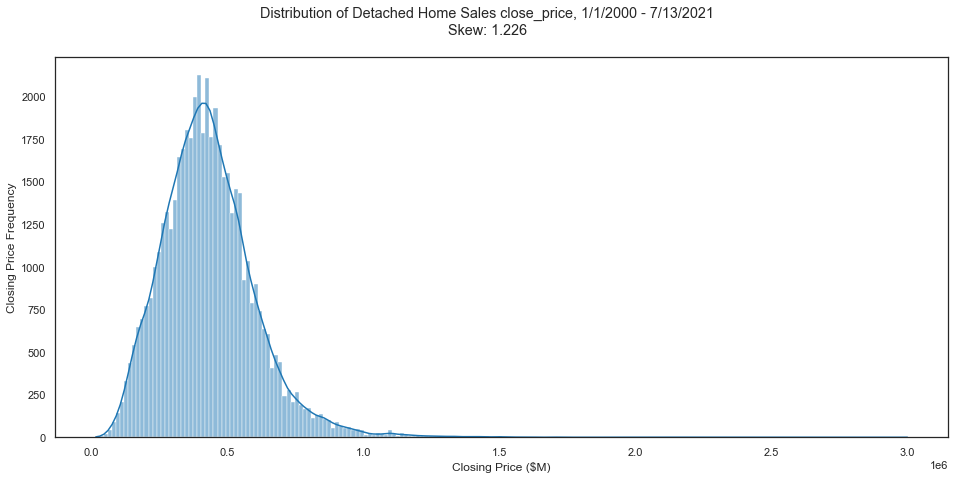

In [23]:
fig1, ax0 = plt.subplots(1, 1, figsize=(16, 7))
fig1.suptitle(f'Distribution of Detached Home Sales close_price, 1/1/2000 - 7/13/2021\n'
              f'Skew: {round(df.close_price.skew(), 3)}')

sns.histplot(data=df,
             x=df.close_price,
             bins= 200,
             kde=True,
             ax = ax0)

ax0.set_xlabel('Closing Price ($M)')
ax0.set_ylabel('Closing Price Frequency')

[Text(0.5, 1.0, 'Log Transformed Distribution\nSkew: -0.617'),
 Text(0.5, 0, 'Log Closing Price (log($M))'),
 Text(0, 0.5, 'Log Closing Price Frequency')]

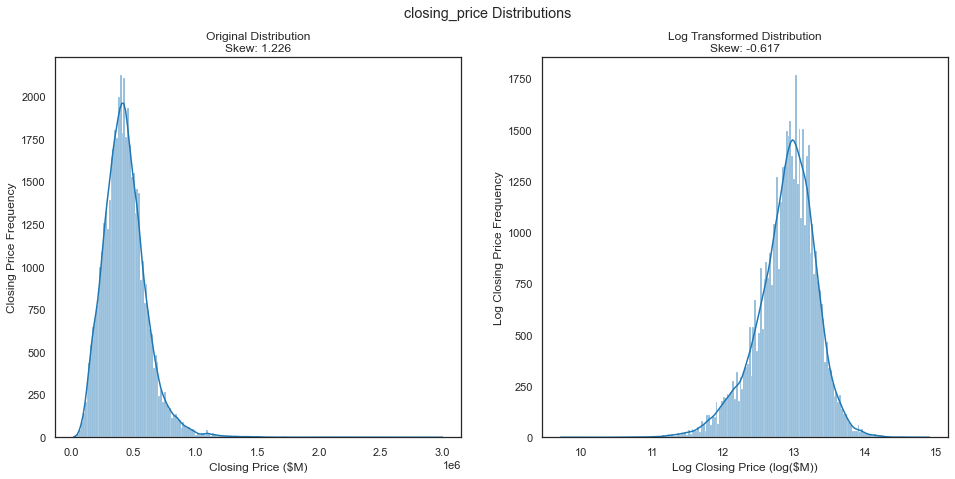

In [24]:
fig2, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 7))

fig2.suptitle('closing_price Distributions')

sns.histplot(data=df,
             x=df.close_price,
             bins=200,
             kde=True,
             ax=ax0)
ax0.set(title=f'Original Distribution\n'
              f'Skew: {round(df.close_price.skew(), 3)}',
        xlabel='Closing Price ($M)',
        ylabel='Closing Price Frequency')

sns.histplot(data=df,
             x=np.log(df['close_price']),
             bins=200,
             kde=True,
             ax=ax1)
ax1.set(title=f'Log Transformed Distribution\n'
              f'Skew: {round(np.log(df.close_price).skew(), 3)}',
        xlabel='Log Closing Price (log($M))',
        ylabel='Log Closing Price Frequency')

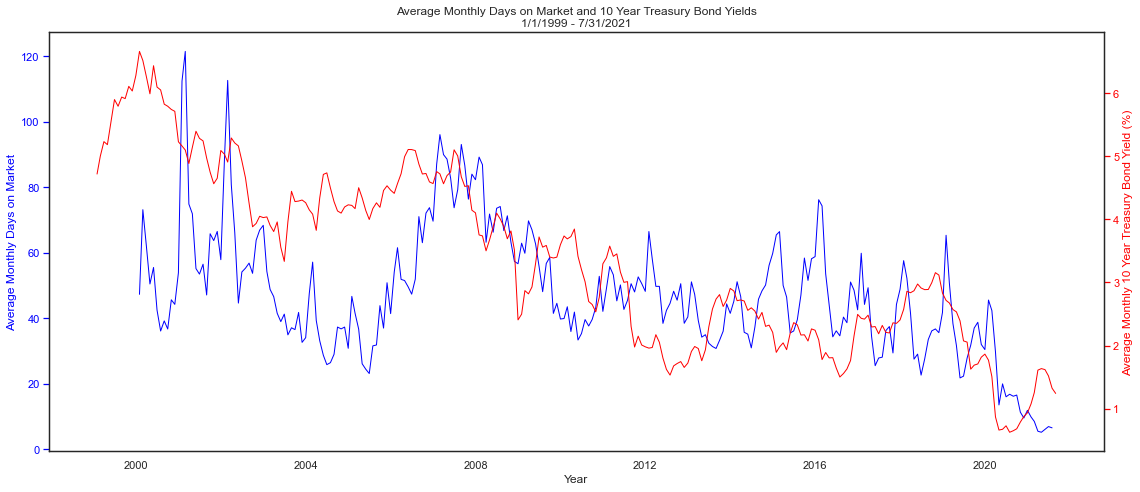

In [25]:
fig3, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.lineplot(data=dom_monthly_df,
             x=dom_monthly_df.index.values,
             y='mean',
             color='blue',
             linewidth=1,
             # label='Average Monthly Days on Market',
             ax=ax0)
ax0.set(title='Average Monthly Days on Market and 10 Year Treasury Bond Yields\n'
              '1/1/1999 - 7/31/2021',
        xlabel='Year',
        ylabel='Average Monthly Days on Market')
ax0.yaxis.label.set_color('blue')
ax0.tick_params(axis='y', colors='blue')

ax1 = ax0.twinx()
sns.lineplot(data=yields_monthly_df,
             x=yields_monthly_df.index.values,
             y='mean',
             color='red',
             linewidth=1,
             # label='Average Monthly 10Yr Treasury Bond Yield (%)',
             ax=ax1)
ax1.set(ylabel='Average Monthly 10 Year Treasury Bond Yield (%)')
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='red')

# fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax0.transAxes)

plt.tight_layout()
fig3.savefig('data/exports/plots/yield_rates_to_dom_lineplot.png')

<AxesSubplot:xlabel='close_date', ylabel='close_price'>

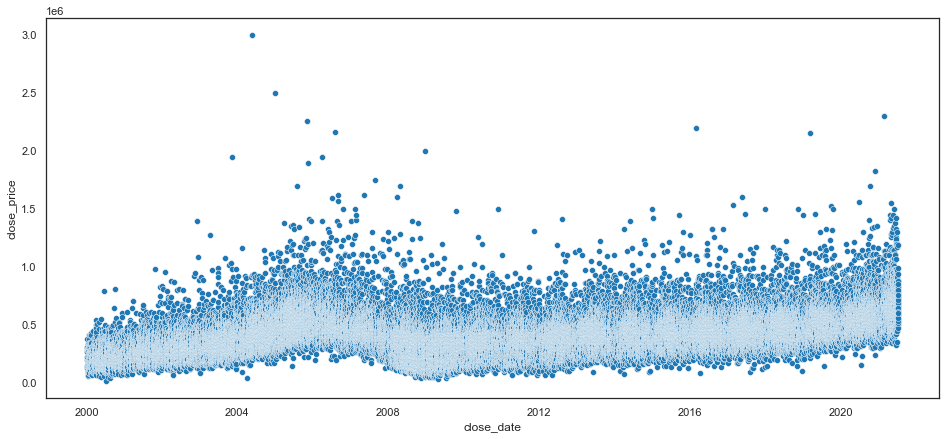

In [26]:
fig4, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(data=df,
                x='close_date',
                y='close_price',
                ax=ax0)

## Modeling

### Create X and y datasets

#### Correlation Matrix

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49461 entries, 0 to 49460
Data columns (total 51 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   mls_#                            49461 non-null  object        
 1   address                          49461 non-null  object        
 2   zip_code                         49461 non-null  object        
 3   city                             49461 non-null  object        
 4   listing_entry_date               49461 non-null  datetime64[ns]
 5   agreement_of_sale_date           49461 non-null  datetime64[ns]
 6   chg_info                         15692 non-null  object        
 7   dom                              49461 non-null  float64       
 8   close_date                       49461 non-null  datetime64[ns]
 9   original_list_price              49461 non-null  int64         
 10  list_price                       49461 non-null  int64    

In [28]:
df.iloc[:, np.r_[11,2,43,12,16,17,18,19,23,24,25,26,30]]

,close_price,zip_code,derived_list_week,year_built,lot_size_sqft,beds,bathrooms_full,bathrooms_half,basement,fireplaces_total,levels_stories,total_garage_spaces,hoa
0,304417,20110,51,1999.0,16453.0,4,2,1.0,1,1.0,3.0,2.0,0
1,311528,20112,1,1999.0,20364.0,4,3,1.0,1,1.0,3.0,2.0,0
2,219500,20155,48,1997.0,13425.0,3,2,1.0,1,1.0,3.0,2.0,0
3,199950,20112,45,1991.0,7980.0,4,2,1.0,1,1.0,3.0,2.0,0
4,274900,20112,38,1995.0,20730.0,5,2,1.0,1,1.0,3.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49456,942000,20181,22,1993.0,435600.0,5,3,1.0,1,1.0,3.0,2.0,0
49457,610000,20112,23,1996.0,21283.0,5,2,1.0,1,1.0,3.0,2.0,1
49458,717000,20136,23,1998.0,11199.0,5,4,1.0,1,1.0,3.0,2.0,1
49459,603500,20181,24,1999.0,90570.0,3,3,1.0,1,2.0,3.0,0.0,0


In [29]:
df = df.iloc[:, np.r_[11,2,43,12,16,17,18,19,23,24,25,26,30]]

In [30]:
df_corr = df[['close_price','derived_list_week','year_built','lot_size_sqft','beds','bathrooms_full','bathrooms_half','basement','fireplaces_total','levels_stories','total_garage_spaces','hoa']].corr()
df_corr

,close_price,derived_list_week,year_built,lot_size_sqft,beds,bathrooms_full,bathrooms_half,basement,fireplaces_total,levels_stories,total_garage_spaces,hoa
close_price,1.000000,-0.056732,0.574591,0.127812,0.386761,0.596589,0.338920,0.338002,0.412473,0.408309,0.507112,0.435318
derived_list_week,-0.056732,1.000000,-0.036784,-0.006939,-0.029651,-0.037169,-0.028263,-0.027925,-0.029292,-0.032907,-0.037292,-0.042492
year_built,0.574591,-0.036784,1.000000,0.002382,0.273828,0.504558,0.467668,0.467640,0.229920,0.597131,0.557270,0.693030
lot_size_sqft,0.127812,-0.006939,0.002382,1.000000,0.020888,0.052055,0.000586,0.014619,0.075757,0.001117,0.061631,-0.049487
beds,0.386761,-0.029651,0.273828,0.020888,1.000000,0.538714,0.246423,0.328503,0.251847,0.387379,0.256030,0.220526
bathrooms_full,0.596589,-0.037169,0.504558,0.052055,0.538714,1.000000,0.128129,0.377933,0.363335,0.397622,0.389844,0.380507
bathrooms_half,0.338920,-0.028263,0.467668,0.000586,0.246423,0.128129,1.000000,0.333397,0.220564,0.541000,0.370677,0.372531
basement,0.338002,-0.027925,0.467640,0.014619,0.328503,0.377933,0.333397,1.000000,0.277825,0.679095,0.310730,0.327241
fireplaces_total,0.412473,-0.029292,0.229920,0.075757,0.251847,0.363335,0.220564,0.277825,1.000000,0.249723,0.314654,0.156013
levels_stories,0.408309,-0.032907,0.597131,0.001117,0.387379,0.397622,0.541000,0.679095,0.249723,1.000000,0.411997,0.462323


<AxesSubplot:>

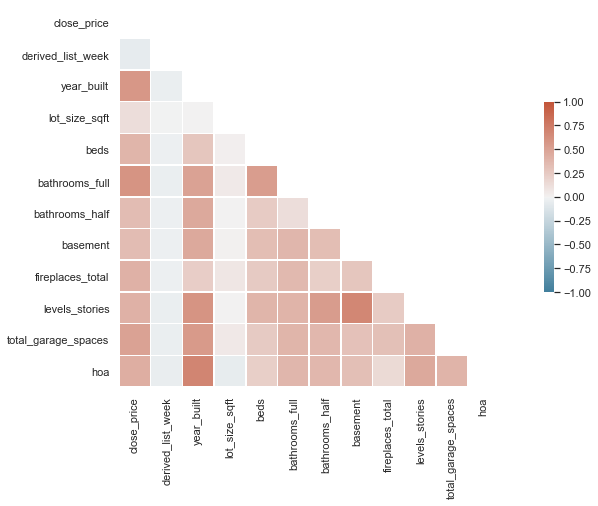

In [31]:
mask = np.triu(np.ones_like(df_corr, dtype=bool))
fig, ax0 = plt.subplots(1, 1, figsize=(16, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            center=0,
            vmin=-1,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5})

#### Split df dataframe into X features matrix and y target series

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49461 entries, 0 to 49460
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   close_price          49461 non-null  int64  
 1   zip_code             49461 non-null  object 
 2   derived_list_week    49461 non-null  int64  
 3   year_built           49461 non-null  float64
 4   lot_size_sqft        49461 non-null  float64
 5   beds                 49461 non-null  int64  
 6   bathrooms_full       49461 non-null  int64  
 7   bathrooms_half       49461 non-null  float64
 8   basement             49461 non-null  int64  
 9   fireplaces_total     49461 non-null  float64
 10  levels_stories       49461 non-null  float64
 11  total_garage_spaces  49461 non-null  float64
 12  hoa                  49461 non-null  int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 6.3+ MB


In [33]:
X = df.iloc[:, np.r_[1:13]]
y = df['close_price']

In [34]:
X_features = list(X.columns)
X_features

['zip_code',
 'derived_list_week',
 'year_built',
 'lot_size_sqft',
 'beds',
 'bathrooms_full',
 'bathrooms_half',
 'basement',
 'fireplaces_total',
 'levels_stories',
 'total_garage_spaces',
 'hoa']

### Split X and y datasets into training and testing datasets

In [35]:
random_seed = 0
train_pct = 0.7
test_pct = 0.3

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_pct,
                                                    train_size=train_pct,
                                                    random_state=random_seed)

In [37]:
print(X_train.info())
print(X_train.head(5).to_string())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34622 entries, 10550 to 2732
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   zip_code             34622 non-null  object 
 1   derived_list_week    34622 non-null  int64  
 2   year_built           34622 non-null  float64
 3   lot_size_sqft        34622 non-null  float64
 4   beds                 34622 non-null  int64  
 5   bathrooms_full       34622 non-null  int64  
 6   bathrooms_half       34622 non-null  float64
 7   basement             34622 non-null  int64  
 8   fireplaces_total     34622 non-null  float64
 9   levels_stories       34622 non-null  float64
 10  total_garage_spaces  34622 non-null  float64
 11  hoa                  34622 non-null  int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 3.4+ MB
None
      zip_code  derived_list_week  year_built  lot_size_sqft  beds  bathrooms_full  bathrooms_half  basement  fireplaces_

### Time Series Analysis

### Shared Modeling Objects

#### Transformers

In [118]:
# numeric_features = []
numeric_features = make_column_selector(dtype_include=np.number)
numeric_features = numeric_features(X_train)
print(numeric_features)

numeric_transformer_std_scaler = Pipeline(steps=[
    ('std_scaler', StandardScaler())])

numeric_transformer_robust_scaler = Pipeline(steps=[
    ('robust_scaler', RobustScaler())])

# categorical_features = ['zip_code']
categorical_features = make_column_selector(dtype_include=[object, 'category'])
categorical_features = categorical_features(X_train)
print(categorical_features)

categorical_transformer_1 = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))])

categorical_transformer_2 = Pipeline(steps=[
    ('ohe', OneHotEncoder())])

feature_preprocessor_1 = ColumnTransformer(transformers=[
    ('categorical', OneHotEncoder(drop='first'), make_column_selector(dtype_include=object))],
    remainder='passthrough')

feature_preprocessor_2 = ColumnTransformer(transformers=[
    ('categorical', OneHotEncoder(drop='first'), make_column_selector(dtype_include=object)),
    ('numerical', StandardScaler(), make_column_selector(dtype_include=np.number))],
    remainder='passthrough')

feature_preprocessor_3 = ColumnTransformer(transformers=[
    ('categorical', OneHotEncoder(drop='first'), make_column_selector(dtype_include=object)),
    ('numerical', RobustScaler(), make_column_selector(dtype_include=np.number))],
    remainder='passthrough')

feature_preprocessor_4 = ColumnTransformer(transformers=[
    ('categorical', OneHotEncoder(), categorical_features),
    ('numerical', StandardScaler(), numeric_features)],
    remainder='passthrough')

feature_preprocessor_kmc = ColumnTransformer(transformers=[
    ('numerical', StandardScaler(), make_column_selector(dtype_include=np.number)),
    ('pca', PCA(n_components=2), make_column_selector(dtype_include=np.number))])

['derived_list_week', 'year_built', 'lot_size_sqft', 'beds', 'bathrooms_full', 'bathrooms_half', 'basement', 'fireplaces_total', 'levels_stories', 'total_garage_spaces', 'hoa']
['zip_code']


In [107]:
pd.DataFrame(feature_preprocessor_2.fit_transform(X_train),
             columns=np.concatenate([feature_preprocessor_2.named_transformers_['categorical'].get_feature_names(),
                                     numeric_features]))

,x0_20110,x0_20111,x0_20112,x0_20136,x0_20155,x0_20169,x0_20181,derived_list_week,year_built,lot_size_sqft,beds,bathrooms_full,bathrooms_half,basement,fireplaces_total,levels_stories,total_garage_spaces,hoa
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.020663,0.490458,-0.261437,0.021802,-0.776168,0.527909,0.42978,0.046746,0.616426,0.443742,0.917706
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.020663,-1.216439,-0.287042,0.021802,0.389920,-1.437388,0.42978,0.046746,-1.073084,-1.619682,-1.089674
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.705906,0.490458,-0.268909,0.021802,0.389920,0.527909,0.42978,0.046746,0.616426,0.443742,0.917706
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.596186,0.490458,-0.279716,-1.255381,0.389920,-1.437388,0.42978,0.046746,0.616426,0.443742,0.917706
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.993667,0.917183,-0.222846,1.298985,1.556007,0.527909,0.42978,0.046746,0.616426,0.443742,-1.089674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34617,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.876782,-2.069888,-0.327361,0.021802,-0.776168,0.527909,0.42978,-1.686046,0.616426,-1.619682,-1.089674
34618,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.596186,0.002773,-0.320972,0.021802,-0.776168,0.527909,0.42978,0.046746,0.616426,0.443742,0.917706
34619,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.418144,1.221986,-0.346139,0.021802,0.389920,0.527909,0.42978,0.046746,0.616426,0.443742,0.917706
34620,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.804842,0.734301,-0.345299,0.021802,1.556007,-1.437388,0.42978,0.046746,0.616426,0.443742,0.917706


### Unsupervised Learning

In [119]:
kmc_pipe = Pipeline(steps=[('preprocessor', feature_preprocessor_kmc),
                           ('regressor', KMeans())])
kmc_pipe.get_params()

kmc_params = [{'regressor__init': ['k-means++', 'random'],
               'regressor__n_clusters': arange(1, 11, 1),
               'regressor__random_state': [0]}]

kmc_gs = GridSearchCV(estimator=kmc_pipe,
                      param_grid=kmc_params,
                      cv=5,
                      verbose=1)

# kmc_scores = cross_val_score(kmc_gs,
#                              X_train,
#                              y_train,
#                              scoring='neg_mean_squared_error')

kmc_gs.fit(X_train.drop(columns=['zip_code']))
kmc_best_params = kmc_gs.best_params_
kmc_best_pipe = kmc_gs.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [120]:
print(kmc_gs.best_params_)
pd.DataFrame(kmc_gs.cv_results_)
# [['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')

{'regressor__init': 'k-means++', 'regressor__n_clusters': 10, 'regressor__random_state': 0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__init,param_regressor__n_clusters,param_regressor__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.088100,0.007870,0.004042,0.000586,k-means++,1,0,"{'regressor__init': 'k-means++', 'regressor__n...",-9.070663e+13,-3.612292e+13,-3.694125e+13,-3.326558e+13,-3.673611e+13,-4.675450e+13,2.201563e+13,19
1,0.224662,0.094260,0.003967,0.000386,k-means++,2,0,"{'regressor__init': 'k-means++', 'regressor__n...",-5.761770e+13,-9.765377e+12,-9.248810e+12,-8.187620e+12,-1.117571e+13,-1.919904e+13,1.923341e+13,17
2,0.160482,0.021780,0.003671,0.000172,k-means++,3,0,"{'regressor__init': 'k-means++', 'regressor__n...",-5.129350e+13,-9.805922e+12,-9.236833e+12,-8.096969e+12,-1.114844e+13,-1.791633e+13,1.671749e+13,16
3,0.201929,0.014446,0.003605,0.000025,k-means++,4,0,"{'regressor__init': 'k-means++', 'regressor__n...",-4.928423e+13,-4.522853e+12,-4.419640e+12,-3.771932e+12,-5.660055e+12,-1.353174e+13,1.788658e+13,14
4,0.198435,0.007235,0.003643,0.000122,k-means++,5,0,"{'regressor__init': 'k-means++', 'regressor__n...",-4.324765e+13,-2.674524e+12,-2.507429e+12,-1.806131e+12,-3.818328e+12,-1.081081e+13,1.623128e+13,6
5,0.207534,0.008869,0.003813,0.000464,k-means++,6,0,"{'regressor__init': 'k-means++', 'regressor__n...",-4.269822e+13,-1.797307e+12,-1.601496e+12,-1.664838e+12,-2.106049e+12,-9.973581e+12,1.636324e+13,5
6,0.260464,0.014580,0.003617,0.000075,k-means++,7,0,"{'regressor__init': 'k-means++', 'regressor__n...",-4.009990e+13,-1.179292e+12,-9.846995e+11,-9.978286e+11,-1.504603e+12,-8.953265e+12,1.557445e+13,4
7,0.286088,0.014225,0.003677,0.000099,k-means++,8,0,"{'regressor__init': 'k-means++', 'regressor__n...",-3.989635e+13,-7.277807e+11,-8.105790e+11,-7.935802e+11,-1.322668e+12,-8.710192e+12,1.559453e+13,3
8,0.305281,0.026466,0.003638,0.000111,k-means++,9,0,"{'regressor__init': 'k-means++', 'regressor__n...",-3.976589e+13,-5.540079e+11,-6.243854e+11,-6.093610e+11,-8.263440e+11,-8.475998e+12,1.564522e+13,2
9,0.309773,0.015241,0.003569,0.000029,k-means++,10,0,"{'regressor__init': 'k-means++', 'regressor__n...",-3.967354e+13,-4.708615e+11,-5.171397e+11,-4.513901e+11,-7.351414e+11,-8.369614e+12,1.565229e+13,1


### Supervised Learning

#### Linear Regression

Base Linear Regression; Target is not transformed, features are not transformed though categorical features are One-hot Encoded

In [ ]:
base_ols_pipe = Pipeline(steps=[('preprocessor', feature_preprocessor_1),
                                ('regressor', LinearRegression())])
base_ols = base_ols_pipe.fit(X_train, y_train)

# print(base_sk_ols.named_steps['regressor'].intercept_)
# print(base_sk_ols.named_steps['regressor'].coef_)
# list(zip(ct_1.get_feature_names(), base_sk_ols.named_steps['regressor'].coef_))

pd.DataFrame(base_ols.named_steps['regressor'].coef_,
             columns=['Coefficients'],
             index=(np.concatenate([base_ols.named_steps['preprocessor'].
                                   transformers_[0][1].named_steps['ohe'].
                                   get_feature_names(),
                                    numeric_features])))

Updated Linear Regression; Target is log-transformed, features are not transformed though categorical features are One-hot Encoded

In [ ]:
# run regression model; target is log-transformed and features are onehot encoded (zip code)
log_level_ols_pipe = Pipeline(steps=[('preprocessor', feature_preprocessor_1),
                                     ('regressor', TransformedTargetRegressor(regressor=LinearRegression(),
                                                                              func=np.log,
                                                                              inverse_func=np.exp))])
log_level_ols = log_level_ols_pipe.fit(X_train, y_train)

print(log_level_ols)

pd.DataFrame(log_level_ols.named_steps['regressor'].regressor_.coef_,
             columns=['Coefficients'],
             index=(np.concatenate([log_level_ols.named_steps['preprocessor'].
                                   transformers_[0][1].named_steps['ohe'].
                                   get_feature_names(),
                                    numeric_features])))

In [ ]:
# run regression model; target is log-transforme and features are scale using Standard Scaler
scaled_ols_pipe = Pipeline(steps=[('preprocessor', feature_preprocessor_2),
                                  ('regressor', TransformedTargetRegressor(regressor=LinearRegression(),
                                                                           func=np.log,
                                                                           inverse_func=np.exp))])
scaled_ols = scaled_ols_pipe.fit(X_train, y_train)

print(scaled_ols)

pd.DataFrame(scaled_ols.named_steps['regressor'].regressor_.coef_,
             columns=['Coefficients'],
             index=(np.concatenate([scaled_ols.named_steps['preprocessor'].
                                   transformers_[0][1].named_steps['ohe'].
                                   get_feature_names(),
                                    numeric_features])))


In [ ]:
# run regression model; target is log-transformed and features are scaled using Robust Scaler
robust_scaled_ols_pipe = Pipeline(steps=[('preprocessor', feature_preprocessor_3),
                                         ('regressor',TransformedTargetRegressor(regressor=LinearRegression(),
                                                                                 func=np.log,
                                                                                 inverse_func=np.exp))])
robust_scaled_ols = robust_scaled_ols_pipe.fit(X_train, y_train)

print(robust_scaled_ols)

pd.DataFrame(robust_scaled_ols.named_steps['regressor'].regressor_.coef_,
             columns=['Coefficients'],
             index=(np.concatenate([robust_scaled_ols.named_steps['preprocessor'].
                                   transformers_[0][1].named_steps['ohe'].
                                   get_feature_names(),
                                    numeric_features])))

#### Use Test dataset to assess model performance

In [ ]:
yhat_base_ols = base_ols.predict(X_test)
yhat_log_level_ols = log_level_ols.predict(X_test)
yhat_scaled_ols = scaled_ols.predict(X_test)
yhat_robust_scaled_ols = robust_scaled_ols.predict(X_test)

In [ ]:
log_level_ols.predict(X_test)

In [ ]:
base_ols_rmse = np.sqrt(mean_squared_error(y_test, yhat_base_ols))
log_level_ols_rmse = np.sqrt(mean_squared_error(y_test, yhat_log_level_ols))
scaled_ols_rmse = np.sqrt(mean_squared_error(y_test, yhat_scaled_ols))
robust_scaled_ols_rmse = np.sqrt(mean_squared_error(y_test, yhat_robust_scaled_ols))

In [ ]:
# base_sk_ols model has lowest RMSE making it the better of the models to use
ols_results = pd.DataFrame({'Model': ['base_ols',
                                      'log_level_ols',
                                      'scaled_ols',
                                      'robust_scaled_ols',],
                            'RMSE': [base_ols_rmse,
                                     log_level_ols_rmse,
                                     scaled_ols_rmse,
                                     robust_scaled_ols_rmse,]})

ols_results


#### K-Nearest Neighbors

In [ ]:
knn_pipe = Pipeline(steps=[('preprocessor', feature_preprocessor_2),
                           ('regressor', KNeighborsRegressor())])
knn_pipe.get_params()

knn_params = [{'regressor__n_neighbors': arange(1, 10, 1)}]

knn_gs = GridSearchCV(estimator=knn_pipe,
                      param_grid=knn_params,
                      cv=5,
                      scoring='neg_mean_squared_error',
                      verbose=1)

knn_scores = cross_val_score(knn_gs,
                             X_train,
                             y_train,
                             scoring='neg_mean_squared_error')

knn_gs.fit(X_train, y_train)
knn_best_params = knn_gs.best_params_
knn_best_pipe = knn_gs.best_estimator_

In [ ]:
print(knn_gs.best_params_)
pd.DataFrame(knn_gs.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')

#### Decision Tree

In [ ]:
tree_pipe = Pipeline(steps=[('preprocessor', feature_preprocessor_1),
                            ('regressor', DecisionTreeRegressor())])
tree_pipe.get_params()
tree_params = [{'regressor__max_depth': [2, 3, 4],
                'regressor__min_samples_split': [2, 3, 4],
                'regressor__random_state': [0]}]

tree_gs = GridSearchCV(estimator=tree_pipe,
                       param_grid=tree_params,
                       cv=5,
                       scoring='neg_mean_squared_error',
                       verbose=1)

# tree_gs_results = pd.DataFrame(tree_gs.cv_results_)

tree_scores = cross_val_score(tree_gs,
                              X_train,
                              y_train,
                              scoring='neg_mean_squared_error')

tree_gs.fit(X_train, y_train)
tree_best_params = tree_gs.best_params_
tree_best_pipe = tree_gs.best_estimator_

In [ ]:
print(tree_gs.best_params_)
pd.DataFrame(tree_gs.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')

#### Random Forest

In [ ]:
rf_pipe = Pipeline(steps=[('regressor', RandomForestRegressor())])
rf_pipe.get_params()

rf_params = [{'regressor__n_estimators': [500],
              'regressor__max_depth': [1, 2, 3, 4],
              'regressor__random_state': [0]}]

rf_gs = GridSearchCV(estimator=tree_pipe,
                     param_grid=tree_params,
                     cv=5,
                     scoring='neg_mean_squared_error',
                     verbose=1)

rf_scores = cross_val_score(rf_gs,
                            X_train,
                            y_train,
                            scoring='neg_mean_squared_error')

rf_gs.fit(X_train, y_train)
rf_best_params = rf_gs.best_params_
rf_best_pipe = rf_gs.best_estimator_

In [ ]:
print(rf_gs.best_params_)
pd.DataFrame(rf_gs.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.barplot(x=rf_gs.best_estimator_.named_steps['regressor'].feature_importances_,
            y=np.concatenate([rf_gs.best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names(), numeric_features]),
            color='blue',
            ax=ax0)
# np.concatenate([rf_gs.best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names(), numeric_features])
# rf_gs.best_estimator_.named_steps['regressor'].feature_importances_
# plt.barh(np.concatenate([rf_gs.best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names(), numeric_features]), rf_gs.best_estimator_.named_steps['regressor'].feature_importances_)

#### Ridge Regression

In [ ]:
ridge_pipe = Pipeline(steps=[('preprocessor', feature_preprocessor_4),
                             ('regressor', Ridge())])
ridge_pipe.get_params()

ridge_params = [{'regressor__alpha': arange(0, 1, 0.01),
                 'regressor__fit_intercept': [True, False],
                 'regressor__normalize': [True, False],
                 'regressor__random_state': [0]}]

ridge_gs = GridSearchCV(estimator=ridge_pipe,
                        param_grid=ridge_params,
                        cv=5,
                        scoring='neg_mean_squared_error',
                        verbose=1)

ridge_scores = cross_val_score(ridge_gs,
                               X_train,
                               y_train,
                               scoring='neg_mean_squared_error')

ridge_gs.fit(X_train, y_train)
ridge_best_params = ridge_gs.best_params_
ridge_best_pipe = ridge_gs.best_estimator_

In [ ]:
print(ridge_gs.best_params_)
pd.DataFrame(ridge_gs.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')

#### Lasso Regression

In [ ]:
lasso_pipe = Pipeline(steps=[('preprocessor', feature_preprocessor_4),
                             ('regressor', Lasso())])
lasso_pipe.get_params()

lasso_params = [{'regressor__alpha': arange(0, 1, 0.01),
                 'regressor__fit_intercept': [True, False],
                 'regressor__normalize': [True, False],
                 'regressor__random_state': [0]}]

lasso_gs = GridSearchCV(estimator=lasso_pipe,
                        param_grid=lasso_params,
                        cv=5,
                        scoring='neg_mean_squared_error',
                        verbose=1)

lasso_scores = cross_val_score(lasso_gs,
                               X_train,
                               y_train,
                               scoring='neg_mean_squared_error')

lasso_gs.fit(X_train, y_train)
lasso_best_params = lasso_gs.best_params_
lasso_best_pipe = lasso_gs.best_estimator_

In [ ]:
print(lasso_gs.best_params_)
pd.DataFrame(lasso_gs.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.lineplot(x=arange(0, 1, 0.01),
             y=lasso_scores.mean(),
             label='Lasso')

sns.lineplot(x=arange(0, 1, 0.01),
             y=ridge_scores.mean(),
             label='Ridge')

### Comparison of Models

#### Use test dataset to assess model performance

In [ ]:
yhat_base_ols = base_ols.predict(X_test)
yhat_knn = knn_gs.predict(X_test)
yhat_tree = tree_gs.predict(X_test)
yhat_rf = rf_gs.predict(X_test)
yhat_ridge = ridge_gs.predict(X_test)
yhat_lasso = lasso_gs.predict(X_test)

In [ ]:
base_ols_rmse = np.sqrt(mean_squared_error(y_test, yhat_base_ols))
knn_rmse = np.sqrt(mean_squared_error(y_test, yhat_knn))
tree_rmse = np.sqrt(mean_squared_error(y_test, yhat_tree))
rf_rmse = np.sqrt(mean_squared_error(y_test, yhat_rf))
ridge_rmse = np.sqrt(mean_squared_error(y_test, yhat_ridge))
lasso_rmse = np.sqrt(mean_squared_error(y_test, yhat_lasso))

In [ ]:
pd.DataFrame({'Model': ['Linear',
                        'KNN',
                        'Tree',
                        'Random Forest',
                        'Ridge',
                        'Lasso'],
              'RMSE': [base_ols_rmse,
                       knn_rmse,
                       tree_rmse,
                       rf_rmse,
                       ridge_rmse,
                       lasso_rmse]})

In [ ]:
new_house = ['20155',
             41,
             2005,
             8912,
             4,
             3,
             1,
             1,
             1,
             3,
             2,
             1]

new_house = pd.DataFrame([new_house], columns=X_train.columns)
print(new_house.to_string())

In [ ]:
print(base_ols_pipe.predict(new_house))
print(knn_gs.predict(new_house))
print(tree_gs.predict(new_house))
print(rf_gs.predict(new_house))
print(ridge_gs.predict(new_house))
print(lasso_gs.predict(new_house))


#### Truths vs Model Predictions Plots

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=yhat_base_ols,
                ax=ax0)

ax0.plot([0, 1],
         [0, 1],
         transform=ax0.transAxes,
         ls='--',
         c='red')

ax0.set_title('Base OLS Model')
ax0.set_xlabel('Truths')
ax0.set_ylabel('Model Predictions')

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=yhat_log_level_ols,
                ax=ax0)

ax0.plot([0, 1],
         [0, 1],
         transform=ax0.transAxes,
         ls='--',
         c='red')

ax0.set_title('Log-Level OLS Model')
ax0.set_xlabel('Truths')
ax0.set_ylabel('Model Predictions')

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=yhat_scaled_ols,
                ax=ax0)

ax0.plot([0, 1],
         [0, 1],
         transform=ax0.transAxes,
         ls='--',
         c='red')

ax0.set_title('Scaled OLS Model')
ax0.set_xlabel('Truths')
ax0.set_ylabel('Model Predictions')

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=yhat_robust_scaled_ols,
                ax=ax0)

ax0.plot([0, 1],
         [0, 1],
         transform=ax0.transAxes,
         ls='--',
         c='red')

ax0.set_title('Robust Scaled OLS Model')
ax0.set_xlabel('Truths')
ax0.set_ylabel('Model Predictions')

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=yhat_knn,
                ax=ax0)

ax0.plot([0, 1],
         [0, 1],
         transform=ax0.transAxes,
         ls='--',
         c='red')

ax0.set_title('KNN Model')
ax0.set_xlabel('Truths')
ax0.set_ylabel('Model Predictions')

In [ ]:

fig, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=yhat_tree,
                ax=ax0)

ax0.plot([0, 1],
         [0, 1],
         transform=ax0.transAxes,
         ls='--',
         c='red')

ax0.set_title('Decision Tree Model')
ax0.set_xlabel('Truths')
ax0.set_ylabel('Model Predictions')

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=yhat_rf,
                ax=ax0)

ax0.plot([0, 1],
         [0, 1],
         transform=ax0.transAxes,
         ls='--',
         c='red')

ax0.set_title('Random Forest Regressor Model')
ax0.set_xlabel('Truths')
ax0.set_ylabel('Model Predictions')

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=yhat_ridge,
                ax=ax0)

ax0.plot([0, 1],
         [0, 1],
         transform=ax0.transAxes,
         ls='--',
         c='red')

ax0.set_title('Ridge Regression Model')
ax0.set_xlabel('Truths')
ax0.set_ylabel('Model Predictions')

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=yhat_lasso,
                ax=ax0)

ax0.plot([0, 1],
         [0, 1],
         transform=ax0.transAxes,
         ls='--',
         c='red')

ax0.set_title('Lasso Regression Model')
ax0.set_xlabel('Truths')
ax0.set_ylabel('Model Predictions')